<a href="https://colab.research.google.com/github/cmysc/hello-world/blob/master/tf_cifar10_load_drawActivations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
print("TensorFlow Version: %s" % tf.__version__)

TensorFlow Version: 1.12.0-rc1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
ls'/content/drive/My Drive/0_neural_network/app/trained_model/'

100batchs/
100batchs_0.55acc/
checkpoint
tf_cifar10.data-00000-of-00001
tf_cifar10_graphModified.data-00000-of-00001
tf_cifar10_graphModified_EP50.data-00000-of-00001
tf_cifar10_graphModified_EP50.index
tf_cifar10_graphModified_EP50.meta
tf_cifar10_graphModified.index
tf_cifar10_graphModified.meta
tf_cifar10.index
tf_cifar10.meta


In [0]:
# loading data
def load_cfar10_batch(load_cifar10_path, batch_id):
   
    with open(load_cifar10_path + 'data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file , encoding='latin1')
    
    # features and labels
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


# for training set

cifar10_path = '/content/drive/My Drive/0_neural_network/app/cifar-10-batches-py/'
# 5 bactches
x_train, y_train = load_cfar10_batch(cifar10_path,1)

ba = [2,3]

for i in ba: #range(2, 6):
#for i in range(2, 6):
    features, labels = load_cfar10_batch(cifar10_path, i)
    x_train, y_train = np.concatenate([x_train, features]), np.concatenate([y_train, labels])

# for testing set
with open(cifar10_path + '/test_batch', mode='rb') as file:
    batch = pickle.load(file , encoding='latin1')
    x_test = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    y_test = batch['labels']

In [0]:
#normalization
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

# reshaope
x_train_rows = x_train.reshape(x_train.shape[0], 32 * 32 * 3)
x_test_rows = x_test.reshape(x_test.shape[0], 32 * 32 * 3)

# scaling to (0,1)
x_train = minmax.fit_transform(x_train_rows)
x_test = minmax.fit_transform(x_test_rows)

# reshape back32 x 32 x 3
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)



In [6]:
#one-hot encoding
from sklearn.preprocessing import LabelBinarizer #MultiLabelBinarizer#
n_class = 10 #总共10类
lb = LabelBinarizer().fit(np.array(range(n_class)))
#lb = MultiLabelBinarizer().fit(np.array(range(n_class)))

print((y_train.shape))

y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

(30000,)


In [0]:
#split testing set

from sklearn.model_selection import train_test_split
test_ratio = 0.2

x_test1, x_test2, y_test1, y_test2 = train_test_split(x_test, 
                                                      y_test, 
                                                      test_size=test_ratio,
                                                      random_state=123)



In [0]:
#inputs & labels (targets)
inputs_ = tf.placeholder(tf.float32, [None, 32, 32, 3], name='inputs_')
targets_ = tf.placeholder(tf.float32, [None, n_class], name='targets_')

In [0]:
def getActivationImage(tensor, numNeuronConv,WidthHeight,drawFalseTrue):
  temp = []
  activationConvlayer = {}

  for k in range(numNeuronConv):

    temp = []
    for i in range(WidthHeight):
        inerList = []
        for j in range(WidthHeight):
            inerList.append( tensor[0][i][j][k]) #tensor[0] due to single image
        # after inerList is scanned append to the outlist "temp"    
        temp.append(inerList)
    # after the square is created by scanning, make it to be numpy array and append to the Conv1_volume layer     
    activationConvlayer[k] = np.array(temp)
   
    if drawFalseTrue:
      fig = plt.figure(figsize=(6, 3.2))

      ax = fig.add_subplot(111)
      ax.set_title('colorMap')
      print('k = ', k)
      plt.imshow(activationConvlayer[k])

      ax.set_aspect('equal')

      cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
      cax.get_xaxis().set_visible(False)
      cax.get_yaxis().set_visible(False)
      #cax.patch.set_alpha(0)
      cax.set_frame_on(False)
      #plt.colorbar(orientation='vertical')
      plt.show()
  
  return activationConvlayer
  


In [0]:
# get single activation value of each ativation image from processed tensor


def getSingleActivationValueVectorByAverage(tensor, numNeuronConv, WidthHeight):
  activationValueVector = {}
  for k in range(numNeuronConv):
    sumTmp = 0.0
    for i in range(WidthHeight):        
        for j in range(WidthHeight):
          sumTmp = float(tensor[0][i][j][k]) +sumTmp
          
    
    activationValueVector.update({k:float(sumTmp)/WidthHeight/WidthHeight})
 
  return activationValueVector

  
  

In [0]:
import operator
def imagesCollectionAfter_true_false_predict(imageIDcollection,imagID, pred,  drawFalseTrue):
  # to seperate true and false predicted images into dictionary
  
  tempLayerDic = {}
  activationValueInLayerDic = {}
  IDmaxInLayer = {}
  ValmaxInLayer ={}
  layer = imageIDcollection[imagID]['raw_tensor']
  
  for layerIDStr, layerTensor in layer.items():
    activationConvlayer = {}
    activationConvlayer = getActivationImage(layerTensor,layerTensor.shape[3],layerTensor.shape[1],drawFalseTrue)
    activationValueVector = getSingleActivationValueVectorByAverage(layerTensor,layerTensor.shape[3],layerTensor.shape[1])
    
    Key_maxActivationInLayer = max(activationValueVector.items(), key=operator.itemgetter(1))[0]
    Val_maxActivationInLayer = max(activationValueVector.items(), key=operator.itemgetter(1))[1]

    tempLayerDic.update({layerIDStr:activationConvlayer})
    activationValueInLayerDic.update({layerIDStr:activationValueVector})
    IDmaxInLayer.update({layerIDStr:Key_maxActivationInLayer})
    ValmaxInLayer.update({layerIDStr:Val_maxActivationInLayer})
    
  
  imageIDcollection[imagID]['processed_tensor'] = tempLayerDic
  imageIDcollection[imagID]['activationValueInLayer'] = activationValueInLayerDic
  imageIDcollection[imagID]['ID_maxActivationInLayer'] = IDmaxInLayer
  imageIDcollection[imagID]['val_maxActivationInLayer'] = ValmaxInLayer
  
    
    
  

In [0]:
NumberOfImageForGraph = 100

In [13]:
# testing
# trained_model path
save_model_path= '/content/drive/My Drive/0_neural_network/app/trained_model/tf_cifar10_graphModified'

import random
img_dict = {}  # data_array
truePredList = []
falsePredList = []
imageIDactivationT = {}
imageIDactivationF = {}

layerName = ['input_image','conv1','conv2','pool2','conv3','conv4','pool4','conv5','conv6','pool6','fc1','fc2','output_pred']
tf.reset_default_graph()
loaded_graph = tf.Graph()
test_batch_size= 1
with tf.Session(graph=loaded_graph) as sess:
  
    # load model
    
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)
   #loader.restore(sess, tf.train.latest_checkpoint('/content/drive/My Drive/0_neural_network/app/trained_model/'))

    # load test_data tensor
    loaded_x = loaded_graph.get_tensor_by_name('inputs_:0')        
    loaded_y = loaded_graph.get_tensor_by_name('targets_:0')
    
    loaded_conv1 = loaded_graph.get_tensor_by_name('conv1/kernel:0')
    loaded_conv2 = loaded_graph.get_tensor_by_name('conv2/kernel:0 ')
    #loaded_pool2 = loaded_graph.get_tensor_by_name('pool2:0')
    #pool2 = tf.layers.max_pooling2d(loaded_conv2, (2,2), (2,2),name='pool2')

    loaded_conv3 = loaded_graph.get_tensor_by_name('conv3/kernel:0 ')
    loaded_conv4 = loaded_graph.get_tensor_by_name('conv4/kernel:0 ')
    #pool4 = tf.layers.max_pooling2d(loaded_conv4, (2,2), (2,2),name='pool4')
    #dropout4 = loaded_graph.get_tensor_by_name('dropout4:0 ')

    #loaded_pool4 = loaded_graph.get_tensor_by_name('pool4:0')
    loaded_conv5 = loaded_graph.get_tensor_by_name('conv5/kernel:0 ')
    loaded_conv6 = loaded_graph.get_tensor_by_name('conv6/kernel:0 ')
    #pool6 = tf.layers.max_pooling2d(loaded_conv6, (2,2), (2,2),name='pool6')

    loaded_fc1 = loaded_graph.get_tensor_by_name('fully_connected/weights:0')
    loaded_fc2 = loaded_graph.get_tensor_by_name('fully_connected_1/weights:0')        
    loaded_logits = loaded_graph.get_tensor_by_name('logits_:0')    
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
    
    
    print ('weight and bias:\n')
    tvars = tf.trainable_variables()
    tvars_vals = sess.run(tvars)
    for var, val in zip(tvars, tvars_vals):
       print(var.name, val.shape)
       #print(var.name, val) 
    

    # compute test_accuracy
    test_batch_acc_total = 0
    test_batch_count = 0
    
    print("Begin test..." +str(x_test1.shape[0]))
    for batch_i in range(x_test1.shape[0]//test_batch_size-8000+NumberOfImageForGraph):  #-1
        test_feature_batch = x_test1[batch_i * test_batch_size: (batch_i+1)*test_batch_size]
        test_label_batch = y_test1[batch_i * test_batch_size: (batch_i+1)*test_batch_size]
        
        test_image = sess.run(loaded_x ,  feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch})
        ########### convolution computed manually to rebuid the cnn layers #########
                
        test_conv1 = tf.nn.convolution(test_image, sess.run(loaded_conv1), padding='SAME',strides=[1,1])   
        res_test_conv1 = sess.run(test_conv1)
        #print('res_test_conv1.shape')
        #print(res_test_conv1.shape)
                
                      
        test_conv2 = tf.nn.convolution(res_test_conv1, sess.run(loaded_conv2), padding='SAME',strides=[1,1])     
        res_test_conv2 = sess.run(test_conv2)
        #print('res_test_conv2.shape')
        #print(res_test_conv2.shape)
               
        pool2 = tf.nn.max_pool(res_test_conv2,ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME',name='pool2')
        res_test_pool2 = sess.run(pool2)
        #print('pool2.shape')
        #print(res_test_pool2.shape)
        
        test_conv3 = tf.nn.convolution(res_test_pool2, sess.run(loaded_conv3), padding='SAME',strides=[1,1])       
        res_test_conv3 = sess.run(test_conv3)
        #print('res_test_conv3.shape')
        #print(res_test_conv3.shape)        
       
        test_conv4 = tf.nn.convolution(res_test_conv3, sess.run(loaded_conv4), padding='SAME',strides=[1,1])       
        res_test_conv4 = sess.run(test_conv4)
        #print('res_test_conv4.shape')
        #print(res_test_conv4.shape)
        
        pool4 = tf.nn.max_pool(res_test_conv4,ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME',name='pool4')
        res_test_pool4 = sess.run(pool4)
        #print('pool4.shape')
        #print(res_test_pool4.shape)
        
        test_conv5 = tf.nn.convolution(res_test_pool4, sess.run(loaded_conv5), padding='SAME',strides=[1,1])       
        res_test_conv5 = sess.run(test_conv5)
        #print('res_test_conv5.shape')
        #print(res_test_conv5.shape)
        
        test_conv6 = tf.nn.convolution(res_test_conv5, sess.run(loaded_conv6), padding='SAME',strides=[1,1])       
        res_test_conv6 = sess.run(test_conv6)
        #print('res_test_conv6.shape')
        #print(res_test_conv6.shape)
        
        pool6 = tf.nn.max_pool(res_test_conv6,ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME',name='pool6')
        res_test_pool6 = sess.run(pool6)
        #print('pool6.shape')
        #print(res_test_pool6.shape)
        
        ###### fully connected not there
        
        
        
        ########
        correct_pred = tf.equal(tf.argmax(loaded_logits, 1), tf.argmax(loaded_y, 1))
        
        test_correct_pred = sess.run(correct_pred,feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch})
        #print("test_correct_pred: %s" %(test_correct_pred[0]))
        trueLabel = sess.run(tf.argmax(loaded_logits, 1), feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch})
        #print(trueLabel)
        prediLabel = sess.run(tf.argmax(loaded_y, 1),feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch})
        #print(prediLabel)                              
       
        # classify the images to be false_pred and true_pred
        #imagesCollectionAfter_true_false_predict(img_dict, truePredList, falsePredList, batch_i, test_correct_pred)
        tempDic = {batch_i: {
                            'raw_tensor':{
                                          'test_input':test_image,
                                          'test_conv1':res_test_conv1,
                                          'test_conv2':res_test_conv2,
                                          'test_pool2':res_test_pool2,
                                          'test_conv3':res_test_conv3,
                                          'test_conv4':res_test_conv4,
                                          'test_pool4':res_test_pool4,
                                          'test_conv5':res_test_conv5,
                                          'test_conv6':res_test_conv6,
                                          'test_pool6':res_test_pool6
                                          },
            
                              'trueOrfalsePred': test_correct_pred[0],
                              'trueLabel':trueLabel[0],
                              'prediLabel':prediLabel[0]
                            }
                   }
        img_dict.update(tempDic)
       # print (img_dict)
            
        
        ############### after got collection of image then print and see    
        
        # call imagesCollectionAfter_true_false_predict(imageIDcollection,imagID, pred0or1, truelabel, prediLabel, drawFalseTrue):        
        imagesCollectionAfter_true_false_predict(img_dict, batch_i, test_correct_pred[0],  0)       
        
       
        #print('------------')
        ''' #structure in dictionary of img_dict
        "imageID: {'raw_tensor':{
                                          'test_input':test_image,
                                          'test_conv1':res_test_conv1,
                                          'test_conv2':res_test_conv2,
                                          'test_pool2':res_test_pool2,
                                          'test_conv3':res_test_conv3,
                                          'test_conv4':res_test_conv4,
                                          'test_pool4':res_test_pool4,
                                          'test_conv5':res_test_conv5,
                                          'test_conv6':res_test_conv6,
                                          'test_pool6':res_test_pool6
                                          ###########
                                          fully connected layer not included 
                                          },
                   'processed_tensor':{
                                          'test_input':test_image,
                                          'test_conv1':res_test_conv1,
                                          'test_conv2':res_test_conv2,
                                          'test_pool2':res_test_pool2,
                                          'test_conv3':res_test_conv3,
                                          'test_conv4':res_test_conv4,
                                          'test_pool4':res_test_pool4,
                                          'test_conv5':res_test_conv5,
                                          'test_conv6':res_test_conv6,
                                          'test_pool6':res_test_pool6
                                          },                       
            
                   'trueOrfalsePred': test_correct_pred,
                    'trueLabel':tf.argmax(loaded_logits, 1), 
                    'prediLabel':tf.argmax(loaded_y, 1)
         }
        
        '''
        #print(img_dict)
        
      
        
        # to calculate average activation values
       
        

        test_batch_acc_total += sess.run(
            loaded_acc,
            feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch})
        test_batch_count += 1

    print('Test Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))
   
    
    

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/0_neural_network/app/trained_model/tf_cifar10_graphModified
weight and bias:

conv1/kernel:0 (3, 3, 3, 48)
conv1/bias:0 (48,)
conv2/kernel:0 (3, 3, 48, 48)
conv2/bias:0 (48,)
conv3/kernel:0 (3, 3, 48, 96)
conv3/bias:0 (96,)
conv4/kernel:0 (3, 3, 96, 96)
conv4/bias:0 (96,)
conv5/kernel:0 (3, 3, 96, 192)
conv5/bias:0 (192,)
conv6/kernel:0 (3, 3, 192, 192)
conv6/bias:0 (192,)
fully_connected/weights:0 (3072, 512)
fully_connected/biases:0 (512,)
fully_connected_1/weights:0 (512, 256)
fully_connected_1/biases:0 (256,)
fully_connected_2/weights:0 (256, 10)
fully_connected_2/biases:0 (10,)
Begin test...8000
Test Accuracy: 0.46



In [14]:
for k,v in img_dict[3].items():
  if k == 'trueLabel':
    print(v)

1


In [15]:
'''
for k,v in img_dict[0]['processed_tensor']['test_conv1'].items():
  print(k)
'''  
  
for k,v in img_dict[0]['val_maxActivationInLayer'].items():
  print(k,v)
print(img_dict[0]['ID_maxActivationInLayer'])
print('------')
#print((img_dict[0]['activationValueInLayer']))
#print(type(img_dict))
print('------')
print((img_dict[0]['ID_maxActivationInLayer']['test_conv1']))
print(len(img_dict[0]['processed_tensor']['test_conv1']))

test_input 0.417792595651008
test_conv1 0.489274482935798
test_conv2 2.3454839914193144
test_pool2 2.6481237314874306
test_conv3 11.77508773189038
test_conv4 173.73882625997066
test_pool4 198.88404870033264
test_conv5 1243.5569219589233
test_conv6 39627.74526977539
test_pool6 49317.5712890625
{'test_input': 0, 'test_conv1': 8, 'test_conv2': 4, 'test_pool2': 4, 'test_conv3': 80, 'test_conv4': 35, 'test_pool4': 35, 'test_conv5': 116, 'test_conv6': 56, 'test_pool6': 56}
------
------
8
48


In [0]:
#get flowOfNode maxActivation Node counting for each layer
def getFlowOfNodeInLayer(classID,img_dict_, layerIDstr):
  print("number of images: %s" %(len(img_dict_)))
  counter = 0
  flowOfNodeInLayer ={}
  tempCounterForEachNodeActivated = []
  for i in range(len(img_dict_)):
    if img_dict_[i]['trueLabel'] == classID: #img_dict_[i]['trueOrfalsePred'] ==1 and 
      counter+=1
      tempCounterForEachNodeActivated.append(img_dict_[i]['ID_maxActivationInLayer'][layerIDstr])
      #flowOfNodeInLayer[img_dict_[i]['ID_maxActivationInLayer'][layerIDstr]]=0

      #print(img_dict_[i]['ID_maxActivationInLayer'][layerIDstr])
  IDs = set(tempCounterForEachNodeActivated)
  for id in IDs:
    ct = 0 
    for x in tempCounterForEachNodeActivated:
      if x == id:
        ct+=1
    flowOfNodeInLayer[id] = ct
    
  #print(IDs)
  print("number of corrected predicted images: %s" %(counter))
  print(flowOfNodeInLayer)
  #print(tempCounterForEachNodeActivated)
  #print(len(tempCounterForEachNodeActivated))
  return flowOfNodeInLayer



In [17]:
# get how many number of neurons in each layer
numNeuronLayer ={}
for k,v in img_dict[0].items():
  print(k)
  #numNeuronLayer[k] = len(img_dict[0]['processed_tensor'][k])
  
print(numNeuronLayer) 
print(len(img_dict[0]['processed_tensor']))

raw_tensor
trueOrfalsePred
trueLabel
prediLabel
processed_tensor
activationValueInLayer
ID_maxActivationInLayer
val_maxActivationInLayer
{}
10


Graph part

In [0]:
import networkx as nx
cnnG = nx.Graph()

In [19]:
#parameters
# nodes -----
pos = {}
attrSet = []
labeldict = {} # make label with all nodes (neurons) 1,2, 3, ...
color_map = []
max_nodeValueInThisLayer = 0
flowOfNode = {} # each node has a flow value

#### for each layer add nodes and edges ###

#for n in range(NumberOfImageForGraph):

for k,v in img_dict[0]['processed_tensor'].items():
  if k == 'test_input':
    yPosInput =1
    nodeCounter = 1
    #----- image input -----
    cnnG.add_node(nodeCounter,name ='inputImage',   pos = [0.5,yPosInput]) #size = activationInput['input'], it should be flowOfNode
    attrSet.append(1) # flowOfNode for inputImage set to be one
    pos[nodeCounter] = [0.5,yPosInput]
    labeldict[1] = "inputImage"
    color_map.append('red')
    flowOfNode[1] = 1 # any number for the input Node ,randomly pick 1
    
  else: #----- other layers -----
    nodeCounter = 1
    temp = []
    print(k)
    flowOfNode = getFlowOfNodeInLayer(1,img_dict, k) #classID, img_dict, layerIDstr 
    
    cnnG.add_node(nodeCounter,name ='inputImage',   pos = [0.5,yPosInput]) #size = activationInput['input'], it should be flowOfNode
    
    
    '''
    for key in sortedActConv1:
        nodeCounter +=1
        temp.append(sortedActConv1[key])
        attrSet.append(sortedActConv1[key])    
        #pos[key] = [1,i*2]
        pos[nodeCounter] = [1,i*numNeuronConv2/numNeuronConv1]
        labeldict[nodeCounter] = key
        color_map.append('red')
        i+=1    
        cnnG.add_node(nodeCounter, name = key,size = sortedActConv1[key], pos = pos[nodeCounter])
        cnnG.add_edge(1, nodeCounter)  

    max_nodeValueInThisLayer = temp.index(max(temp))
    #print max_nodeValueInThisLayer
    #print temp
    color_map[1+max_nodeValueInThisLayer] = 'green'
    #print color_map
    '''


print(cnnG.node(data=True))



test_conv1
number of images: 100
number of corrected predicted images: 13
{8: 13}
test_conv2
number of images: 100
number of corrected predicted images: 13
{4: 13}
test_pool2
number of images: 100
number of corrected predicted images: 13
{4: 13}
test_conv3
number of images: 100
number of corrected predicted images: 13
{80: 13}
test_conv4
number of images: 100
number of corrected predicted images: 13
{35: 13}
test_pool4
number of images: 100
number of corrected predicted images: 13
{35: 13}
test_conv5
number of images: 100
number of corrected predicted images: 13
{116: 13}
test_conv6
number of images: 100
number of corrected predicted images: 13
{56: 13}
test_pool6
number of images: 100
number of corrected predicted images: 13
{56: 13}
[(1, {'name': 'inputImage', 'pos': [0.5, 1]})]


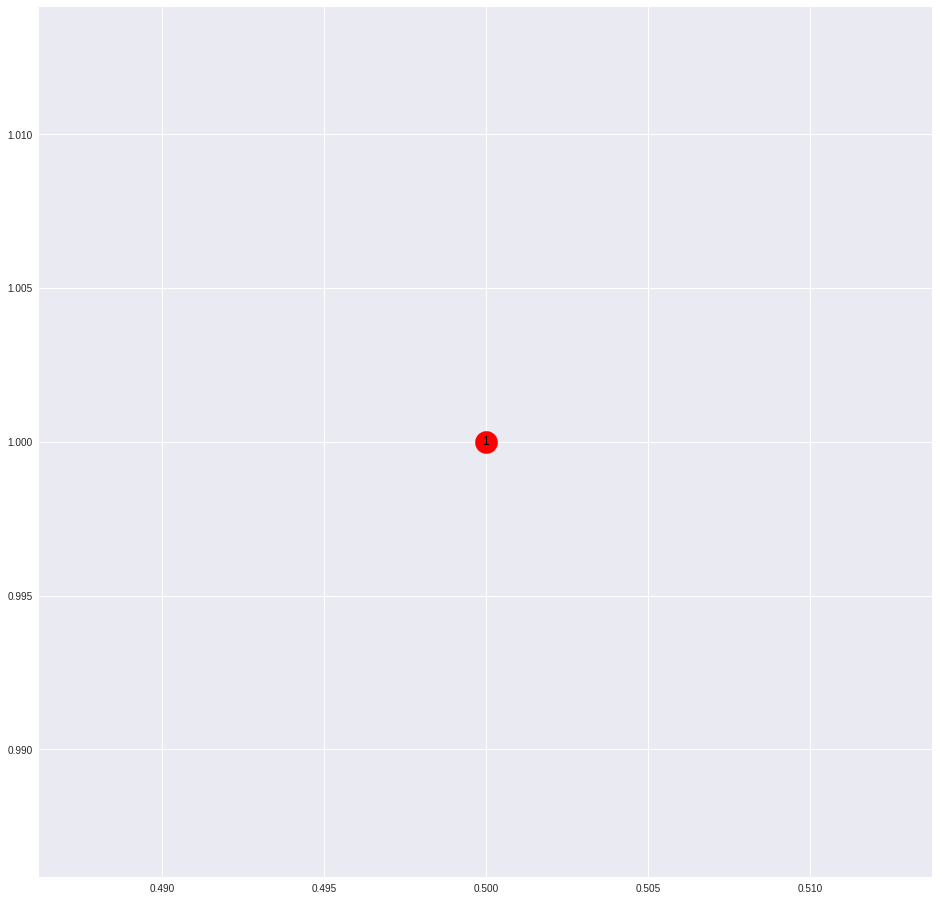

In [20]:


plt.figure(1,figsize=(16,16))

# rescale the size attribute of node
enlargedAttrSet = [i * 500 for i in attrSet]

nx.draw_networkx(cnnG, pos,  with_labels=True, node_size = enlargedAttrSet,node_color = color_map)#
plt.draw()